<a href="https://colab.research.google.com/github/primasr/TugasTeknologiMultimedia/blob/main/TugasDCT_TeknologiMultimedia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **JPEG Compression**

Steps of the JPEG compression are listed below: 

1. Description of DCT
2. Reason for Quantization & Quantization Arrays
3. Block Splitting
4. Dividing into parts
5. Discrete Cosine Transform
6. Inverse Discrete Cosine Transform
7. Complete the Puzzle
8. Fourier Comparison of Original Image vs JPEG Compressed Image (Upcoming soon...)
9. Huffman Coding for More Space (Upcoming soon...)
10. Results

In [17]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from matplotlib import cm

import os

def showImage(img):
    plt.imshow(img, cmap="gray")
    plt.xticks([]),plt.yticks([])
    plt.show()


## **Description of DCT**

> This is an example code for JPEG image compression. The algorithm behind the JPEG standart comes from Discrete Cosine Transform. A discrete cosine transform (DCT) expresses a finite sequence of data points in terms of a sum of cosine functions oscillating at different frequencies. Therefore, an image can be represtented with linear combinations of Discrete Cosine Transform coefficients. 

![DCT](https://users.cs.cf.ac.uk/Dave.Marshall/Multimedia/DCT.jpg)

 > The DCT transforms an 8×8 block of input values to a linear combination of these 64 patterns. The patterns are referred to as the two-dimensional DCT basis functions, and the output values are referred to as transform coefficients. The top left corner of the transform image represtents lowest frequency, when we move to bottom right corner we are encountering higher frequencies. An image is actually includes most of those frequencies, as I said in first sentence the image can be represtent with linear combinations of those parts of the frequency blocks.

## **Reason for Quantization & Quantization Arrays**
>  The human eye is good at seeing small differences in brightness over a relatively large area, but not so good at distinguishing the exact strength of a high frequency brightness variation. This allows one to greatly reduce the amount of information in the high frequency components. This is done by simply dividing each component in the frequency domain by a constant for that component, and then rounding to the nearest integer. This rounding operation is the only lossy operation in the whole process (other than chroma subsampling) if the DCT computation is performed with sufficiently high precision. As a result of this, it is typically the case that many of the higher frequency components are rounded to zero, and many of the rest become small positive or negative numbers, which take many fewer bits to represent.

> Since** DCT coefficient will be divided to quantization arrays elementwise**, the higher value on quantization array will cause higher compression to image. We are expecting to see image size on disk  

> *(Resulted image Q10)<(Resulted image Q50)<(Resulted image Q90).*

In [18]:
#Quantization Arrays

def selectQMatrix(qName):
    Q10 = np.array([[80,60,50,80,120,200,255,255],
                [55,60,70,95,130,255,255,255],
                [70,65,80,120,200,255,255,255],
                [70,85,110,145,255,255,255,255],
                [90,110,185,255,255,255,255,255],
                [120,175,255,255,255,255,255,255],
                [245,255,255,255,255,255,255,255],
                [255,255,255,255,255,255,255,255]])

    Q50 = np.array([[16,11,10,16,24,40,51,61],
                [12,12,14,19,26,58,60,55],
                [14,13,16,24,40,57,69,56],
                [14,17,22,29,51,87,80,62],
                [18,22,37,56,68,109,103,77],
                [24,35,55,64,81,104,113,92],
                [49,64,78,87,103,121,120,101],
                [72,92,95,98,112,100,130,99]])

    Q90 = np.array([[3,2,2,3,5,8,10,12],
                    [2,2,3,4,5,12,12,11],
                    [3,3,3,5,8,11,14,11],
                    [3,3,4,6,10,17,16,12],
                    [4,4,7,11,14,22,21,15],
                    [5,7,11,13,16,12,23,18],
                    [10,13,16,17,21,24,24,21],
                    [14,18,19,20,22,20,20,20]])
    if qName == "Q10":
        return Q10
    elif qName == "Q50":
        return Q50
    elif qName == "Q90":
        return Q90
    else:
        return np.ones((8,8)) #it suppose to return original image back


## **The Original Image**
> I called showImage function, which is defined above.
> You can choose between those 4 images which are located in input folder by changing the directory variable.

(592, 392)


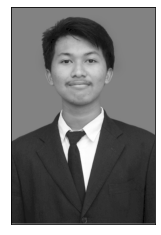

In [19]:
directory = 'FOTO IJAZAH.png'
img = cv2.imread(directory,0)

plt.imshow(img, interpolation='nearest',cmap='gray')
plt.imsave('img_awal.png', img, cmap="gray")

print(img.shape)

showImage(img)

## **Block Splitting**
>  Block splitting is one of the processes that splice the image into smaller blocks of 8×8 or a 16×16 dimension. The important thing to understand is why this is done.
> 
> Assume that we have a 256×256 image. Split these into 1024 8×8 blocks. Now, knowing that the computation complexity for the 2-dimensional DCT operation is O(N^4) and O((N log2N)^2) considering the Fast Cosine Transform, 
> we still have 2564^4 >> (256xlog2256)^2 >> 1024 x (8xlog28 )^2
> which proves that its advisable to split and perform the operations.


>  And the First move is reading image with using OpenCV then, extract height and width of the giving image.  I will be used those variables  for splitting operation.  I am creating an empty list for storing sliced image into 8x8 blocks. "block" parameter deciding the block size of sliced image.

In [20]:
height  = len(img) #one column of image
width = len(img[0]) # one row of image
sliced = [] # new list for 8x8 sliced image 
block = 8
print("The image heigh is " +str(height)+", and image width is "+str(width)+" pixels")

The image heigh is 592, and image width is 392 pixels


## **Dividing into parts**
> I know it is not the best way to splitting image into small pieces but it works well. Later I am planning to improve these upcoming lines.

> Before computing the DCT of the 8×8 block, its values are shifted from a positive range to one centered on zero. For an 8-bit image, each entry in the original block falls in the range [0,255] . The midpoint of the range (in this case, the value 128) is subtracted from each entry to produce a data range that is centered on zero, so that the modified range is [-128,127] . This step reduces the dynamic range requirements in the DCT processing stage that follows.

In [21]:
#dividing 8x8 parts
currY = 0 #current Y index
for i in range(block,height+1,block):
    currX = 0 #current X index
    for j in range(block,width+1,block):
        sliced.append(img[currY:i,currX:j]-np.ones((8,8))*128) #Extracting 128 from all pixels
        currX = j
    currY = i
    
print("Size of the sliced image: "+str(len(sliced)))
print("Each elemend of sliced list contains a "+ str(sliced[0].shape)+ " element.")


Size of the sliced image: 3626
Each elemend of sliced list contains a (8, 8) element.


Since *cv2.dct* operation requires floating numbers for discrete cosine transform, I am executing a int2float transform here. List comprehension is the easiest way to do so.

In [22]:
imf = [np.float32(img) for img in sliced]

## **Finally: Discrete Cosine Transform**
> *cv2.dct* performs a forward or inverse discrete Cosine transform of 1D or 2D array.

> Parameters of  cv2.dct(***input floating-point array***,***output array of the same size and type as source***,***inverse or forward flag***)

> The following lines just calculating the DCT of blocks and append all blocks into *DCToutput*  list.

In [23]:
DCToutput = []
for part in imf:
    currDCT = cv2.dct(part)
    DCToutput.append(currDCT)
DCToutput[0][0]

array([-63.999996,   0.      ,   0.      ,   0.      ,   0.      ,
         0.      ,   0.      ,   0.      ], dtype=float32)

> Again a very very computionaly costy algorithm here. The following code quantize the each pixel in blocks. 

> Notice that most of the higher-frequency elements of the sub-block (i.e., those with an x or y spatial frequency greater than 4) are compressed into zero values.

> You can rearrange the Quantization matrix by chancing selectQMatrix input, avaiable Q. Matrix are: "Q10", "Q50" and "Q90". 

In [24]:
selectedQMatrix = selectQMatrix("Q10")
for ndct in DCToutput:
    for i in range(block):
        for j in range(block):
            ndct[i,j] = np.around(ndct[i,j]/selectedQMatrix[i,j])
DCToutput[0][0]

array([-1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], dtype=float32)

As we can see quantization is completed. The size has been recuded. Now reconstruct the image back.

## **Inverse Discrete Cosine Transform**
> *cv2.idct()* calculates inverse Discrete Cosine Transform of 1D or 2D array.
> Parameters of  cv2.idct are same with cv2.dct.

In [25]:
invList = []
for ipart in DCToutput:
    ipart
    curriDCT = cv2.idct(ipart)
    invList.append(curriDCT)
invList[0][0]

array([-0.12499999, -0.12499999, -0.12499999, -0.12499999, -0.12499999,
       -0.12499999, -0.12499999, -0.12499999], dtype=float32)

## **Complete the Puzzle**
> In the following code, we are putting the image parts together. As we can observe on *invList* is one dimentional list that contains 8x8 numpy arrays inside it. In order to recover the image:
> 1.  *invList* elements should be parsed at *width/block* steps. For example: If the image width is 1200 pixels, parsing steps should be 1200/8=150 pixels
> 2. Use *np.hstack* if you are going to recover the image's rows first, else use *np.vstack* for recover columns first.
> 3. Append all recovered columns into another list.
> 4. Apply *np.vstack* if you have been used *np.hstack*, reverse order with entry 2.

In [26]:
row = 0
rowNcol = []
for j in range(int(width/block),len(invList)+1,int(width/block)):
    rowNcol.append(np.hstack((invList[row:j])))
    row = j
res = np.vstack((rowNcol))

## **Results**
> There it is, the compressed image. As you can see the image lost some high frequency components and it causes reduced size on disk. There is no change in total pixel count, the JPEG did not reduce the size of the image, it just cancelled out high frequencies.

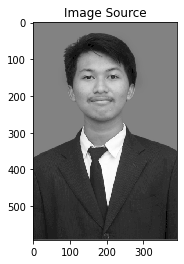

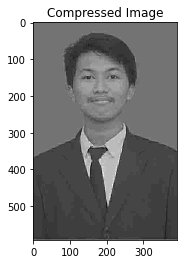

Memory size RGB        :  351685  bytes
Memory size BnW Before :  99058  bytes
Memory size BnW After  :  42243  bytes
Compression ratio RGB Before - BnW After:  87.98840 %
Compression ratio BnW Before - BnW After:  57.35529 %
MSE:  156.86715302675125
PSNR:  26.17548346233502  dB
SNR:  1.9965086545922395  dB
SNR:  3.287503105349461  dB


In [27]:
# show result and save it
plt.title("Image Source")
plt.imshow(img, interpolation='nearest',cmap='gray')
plt.show()

plt.title("Compressed Image")
plt.imshow(res, interpolation='nearest',cmap='gray')
plt.imsave('img_akhir.png', res, cmap="gray")
plt.show()

# read file
hehe1 = cv2.imread('img_awal.png')
hehe2 = cv2.imread('img_akhir.png')

# get image size
msize_awal_rgb = os.path.getsize(directory)
msize_awal = os.path.getsize('img_awal.png')
msize_akhir = os.path.getsize('img_akhir.png')
print("Memory size RGB        : ",msize_awal_rgb," bytes")
print("Memory size BnW Before : ",msize_awal," bytes")
print("Memory size BnW After  : ",msize_akhir," bytes")

# compression ratio rgb
rgb_fix = ((msize_awal_rgb - msize_akhir)*100)/msize_awal_rgb
formatted_ratio_rgb = "{:.5f}".format(rgb_fix)
print("Compression ratio RGB Before - BnW After: ", formatted_ratio_rgb, "%")

# compression ratio BnW
bnw_fix = ((msize_awal - msize_akhir)*100)/msize_awal
formatted_ratio_bnw = "{:.5f}".format(bnw_fix)
print("Compression ratio BnW Before - BnW After: ", formatted_ratio_bnw, "%")

# show MSE
print("MSE: ", np.square(np.subtract(hehe1,hehe2)).mean())

# PSNR function
from math import log10, sqrt
def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr

print("PSNR: ", PSNR(hehe1, hehe2), " dB")

#SNR function
import scipy.io
def signaltonoise(a, axis=0, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, m/sd)

print("SNR: ", signaltonoise(hehe1).flatten().mean(), " dB")
print("SNR: ", signaltonoise(hehe2).flatten().mean(), " dB")